In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '../')

from shocksgo import generate_stellar_fluxes

In [2]:
from astropy.constants import M_sun, L_sun, R_sun
import astropy.units as u

mass = 1 * M_sun
teff = 5777 * u.K
lum = 1 * L_sun

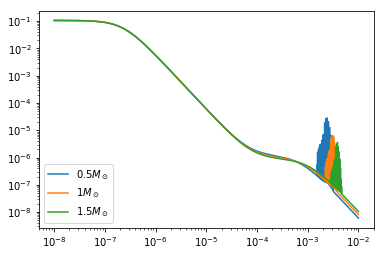

In [3]:
freqs = np.logspace(-8, -2, 50000)

_, _, kernel_sun = generate_stellar_fluxes(10*u.min, mass, teff, R_sun, lum)
_, _, kernel_05 = generate_stellar_fluxes(10*u.min, 0.5 * M_sun, teff, 0.8 * R_sun, lum)
_, _, kernel_15 = generate_stellar_fluxes(10*u.min, 1.5 * M_sun, teff, 1.1 * R_sun, lum)

plt.loglog(freqs, kernel_05.get_psd(2 * np.pi * freqs), label='$0.5M_\odot$')
plt.loglog(freqs, kernel_sun.get_psd(2 * np.pi * freqs), label='$1M_\odot$')
plt.loglog(freqs, kernel_15.get_psd(2 * np.pi * freqs), label='$1.5M_\odot$')
plt.legend(loc='lower left')

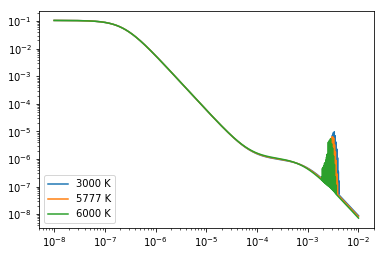

In [4]:
_, _, kernel_hot = generate_stellar_fluxes(10*u.min, mass, 7000 * u.K,  R_sun, lum)
_, _, kernel_cool = generate_stellar_fluxes(10*u.min, mass, 5000 * u.K, R_sun, lum)

plt.loglog(freqs, kernel_cool.get_psd(2 * np.pi * freqs), label='3000 K')
plt.loglog(freqs, kernel_sun.get_psd(2 * np.pi * freqs), label='5777 K')
plt.loglog(freqs, kernel_hot.get_psd(2 * np.pi * freqs), label='6000 K')
plt.legend(loc='lower left')

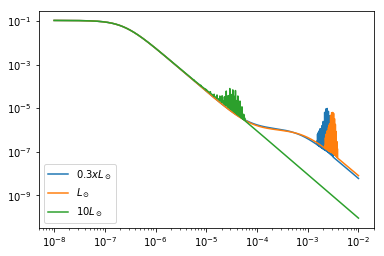

In [5]:
_, _, kernel_dwarf = generate_stellar_fluxes(10*u.min, 0.5 * M_sun, teff, 0.8 * R_sun, 0.3*lum)
_, _, kernel_giant = generate_stellar_fluxes(10*u.min, mass, 5000 * u.K, 10 * R_sun, 10*lum)

plt.loglog(freqs, kernel_dwarf.get_psd(2 * np.pi * freqs), label='$0.3x L_\odot$')
plt.loglog(freqs, kernel_sun.get_psd(2 * np.pi * freqs), label='$L_\odot$')
plt.loglog(freqs, kernel_giant.get_psd(2 * np.pi * freqs), label='$10 L_\odot$')
plt.legend(loc='lower left')